In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# append main directory so it is possible to import from src
import sys
sys.path.append('../')

In [4]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

from src.config import prepare_config
from src.torch.dataset import data_split
from src.torch.utils import to_np

c:\Users\User\Desktop\МЭИ\NIR\cv_basics\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
dataset_params = prepare_config('../params.yaml', config_key='dataset', resolve=True)

dataset_params['train_batch_size'] = 10 
dataset_params['val_batch_size'] = 10
dataset_params['test_batch_size'] = 10
dataset_params['root'] = '../data/CIFAR10'
dataset_params['num_workers'] = 1

In [8]:
train_dataloader, val_dataloader, test_dataloader = data_split(**dataset_params)

In [10]:
idx2class = train_dataloader.dataset.idx2class_mapping

In [9]:
for batch in train_dataloader:
    x, y = batch
    break

In [56]:
def vis_batch(x, y=None, idx2class: dict = None):
    """
    Inputs:
    x - Tensor representening the batch of images with shape [B, C, H, W]
    """
    batch_size = x.shape[0]
    fig, ax = plt.subplots(nrows=1, ncols=batch_size, figsize=(12, 12))

    for idx, image in enumerate(x):
        ax[idx].imshow(to_np(image).transpose(1, 2, 0))
        ax[idx].axis("off")
        if y is not None:
            title = idx2class[int(y[idx])] if idx2class is not None else int(y[idx])
            ax[idx].set_title(title)
    plt.show()

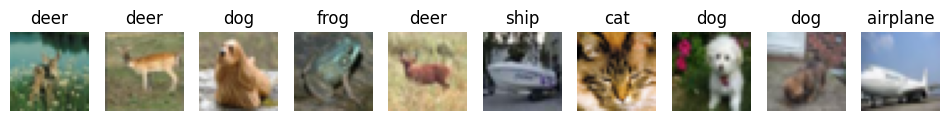

In [34]:
vis_batch(x, y, idx2class)

In [62]:
def img_to_patch(x_batch, patch_size, flatten_channels=True):
    B, C, H, W = x.shape
    x_batch = x_batch.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size)
    x_batch = x_batch.permute(0, 2, 4, 1, 3, 5)  # [B, H', W', C, p_H, p_W]
    x_batch = x_batch.flatten(1, 2)  # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x_batch = x_batch.flatten(2, 4)  # [B, H'*W', C*p_H*p_W]
    return x_batch   

In [54]:
patches = img_to_patch(x, 4, False)

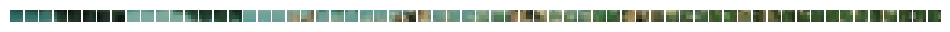

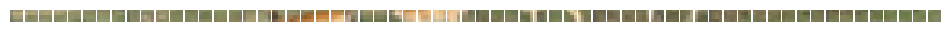

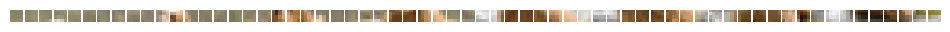

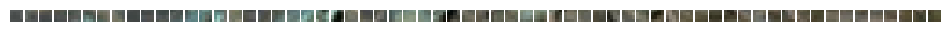

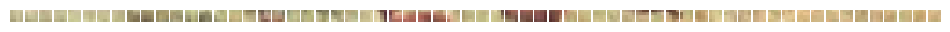

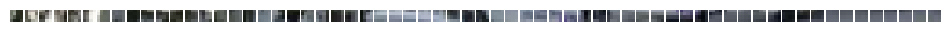

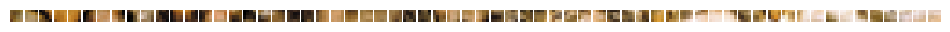

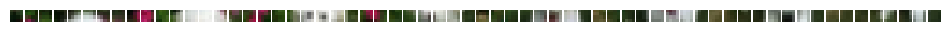

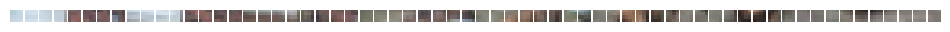

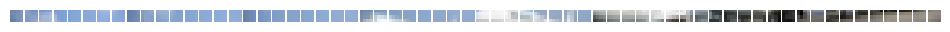

In [58]:
for patch in patches:
    vis_batch(patch)

In [60]:
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
        """
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

In [61]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        embed_dim,
        hidden_dim,
        num_channels,
        num_heads,
        num_layers,
        num_classes,
        patch_size,
        num_patches,
        dropout=0.0,
    ):
        """
        Inputs:
            embed_dim - Dimensionality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of the input (3 for RGB)
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and
                      on the input encoding
        """
        super().__init__()

        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nn.Linear(num_channels * (patch_size**2), embed_dim)
        self.transformer = nn.Sequential(
            *(AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers))
        )
        self.mlp_head = nn.Sequential(nn.LayerNorm(embed_dim), nn.Linear(embed_dim, num_classes))
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))

    def forward(self, x):
        # Preprocess input
        x = img_to_patch(x, self.patch_size)
        B, T, _ = x.shape
        x = self.input_layer(x)

        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.pos_embedding[:, : T + 1]

        # Apply Transforrmer
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)

        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

In [ ]:
from torch.optim.lr_scheduler